In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import random
import scipy
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pytensor.tensor as pt

def get_coef_table(lin_reg):
    ''' lin_reg is a fitted statsmodels regression model
    Return a dataframe containing coefficients, pvalues, and the confidence intervals
    '''
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:],
                            'varname': err_series.index.values[1:]
                           })
    return coef_df

In [108]:
import numpy as np
import pandas as pd
import scipy

np.random.seed(46)

data_params = {'n_items': 10,
               'n_stores': 300,
               'n_days': 140,
               'price_lower': 500,
               'price_upper': 2000}

# Calculating price elasticity matrix. This is what we want to recover in the end.
price_elasticity_matrix_comp = np.random.normal(loc=0.5, 
                                                scale=1, 
                                                size=(data_params['n_items'], data_params['n_items'])) / 2
price_elasticity_matrix_comp = np.round((price_elasticity_matrix_comp)*(price_elasticity_matrix_comp < -0.2), 1)

price_elasticity_matrix_own = np.random.normal(loc=-1.2, 
                                                scale=0.2, 
                                                size=(data_params['n_items'], data_params['n_items']))
price_elasticity_matrix_own = np.where(price_elasticity_matrix_own > -0.2, -0.7, price_elasticity_matrix_own) * \
                              np.identity(data_params['n_items'])
price_elasticity_matrix_own = np.round(price_elasticity_matrix_own, 1)

price_elasticity_matrix = price_elasticity_matrix_own + price_elasticity_matrix_comp


# Creating each item and its price for each day in each store.
item_usual_price = np.round(np.random.uniform(500, 2000, size=data_params['n_items']), -1)
df = pd.DataFrame(columns=['item_id', 'day', 'store', 'price', 'quantity'])
for item_id, price in enumerate(item_usual_price):
    n_observations = data_params['n_days']*data_params['n_stores']
    day_prices = np.round(scipy.stats.truncnorm.rvs(loc=price, scale=200, a=1, b=3, size=data_params['n_days']), -1)
    store_day_prices = np.repeat(day_prices, data_params['n_stores'])
    item_ids = [item_id for _ in range(n_observations)]
    store_ids = np.arange(data_params['n_stores'])
    day_ids = np.arange(data_params['n_days'])
    store_day_ids = np.array(np.meshgrid(day_ids, store_ids)).T.reshape(-1, 2)
    data = pd.DataFrame({'item_id': item_ids, 
                         'day': store_day_ids[:,0].flatten(),
                         'store': store_day_ids[:,1].flatten(),
                         'price': store_day_prices})
    df = pd.concat([df, data])
    if item_id % 5 == 0:
        print(f"{item_id}/{data_params['n_items']}")

average_product_quantity = np.random.exponential(10, size=data_params['n_items'])+5
store_quantity_modifier = scipy.stats.truncnorm.rvs(loc=1, scale=1, a=-0.7, b=3, size=data_params['n_stores'])
day_quantity_modifier = scipy.stats.truncnorm.rvs(loc=1, scale=0.1, a=-0.5, b=2, size=data_params['n_days'])

ixs = df.pivot(index=['day', 'store'], columns=['item_id'], values=['price'])
ixs.columns = [f"vs_{i[1]}" for i in ixs.columns.values]
ixs = ixs.reset_index()

df = df.merge(ixs, on=['day', 'store'], how='left')
# for c in [c for c in df.columns.values if "vs_" in c]:
#     df.loc[:,c] = df['price']/df.loc[:,c] 

def cross_elasticity_q(item_id, price, columns):
    #print(item_id)
    # print(columns)
    res = 1
    for i, (col, beta) in enumerate(zip(columns.values, price_elasticity_matrix[item_id])):
        if i == item_id:
            continue
        res *= (price/col)**beta
    return res

intercept = 10**4

# This is the main line which computes 
df['quantity'] = intercept * \
                 df['item_id'].apply(lambda x: average_product_quantity[x]) * \
                 df['price']**df['item_id'].apply(lambda x: price_elasticity_matrix[x, x]) * \
                 df[['item_id', 'price'] + [c for c in df.columns.values if "vs_" in c]].apply(lambda x: cross_elasticity_q(x[0], x[1], x[2:]), axis=1) * \
                 df['day'].apply(lambda x: day_quantity_modifier[x]) * \
                 df['store'].apply(lambda x: store_quantity_modifier[x])

df['quantity'] = np.round(df['quantity'], 0)

# This is masked DF as would be seen in real sales data.
# Without factoring in that we do not always see the IX vs competition.
dfm = df[df['quantity'] > 0]

0/10
5/10


In [109]:
def replace_ix_to_PPU(x):
    item_n = x['item_id'].values[0]
    x[f'vs_{item_n}'] = x['price']
    return x
dfm = dfm.groupby('item_id').apply(replace_ix_to_PPU).droplevel(0, axis=0)
dfm['item_id'] = dfm['item_id'].astype(int)
dfm['day'] = dfm['day'].astype(int)
dfm['store'] = dfm['store'].astype(int)


<Axes: xlabel='price', ylabel='quantity'>

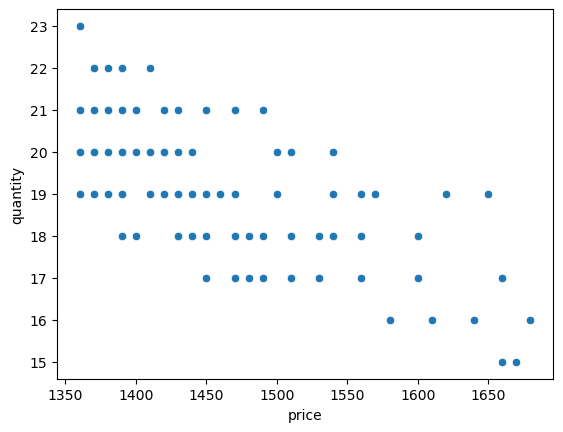

In [145]:
sns.scatterplot(data=dfm[(dfm['item_id']==0) & (dfm['store']==17)], x='price', y='quantity')

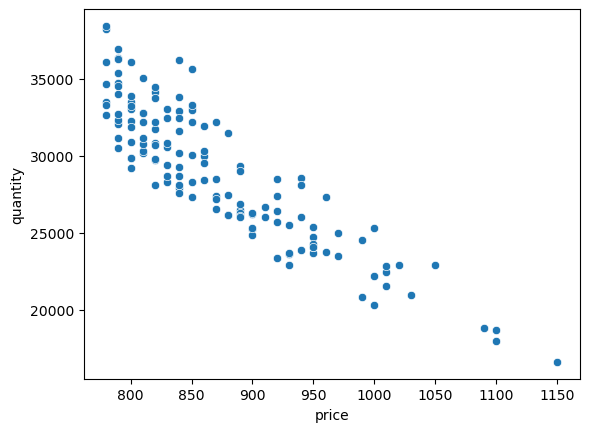

In [146]:
# Grouped dataset so see if scatter plots look correct

dfm['value_sales'] = dfm['quantity']*dfm['price']
dfg = dfm.groupby(by=['day', 'item_id']).agg({"quantity":'sum', 'value_sales':'sum'}).reset_index()
dfg['price'] = dfg['value_sales']/dfg['quantity']
ixsg = dfg.pivot(index=['day'], columns=['item_id'], values=['price'])
ixsg.columns = [f"vs_{i[1]}" for i in ixsg.columns.values]
ixsg = ixsg.reset_index()
dfg = dfg.merge(ixsg, on=['day'], how='left')
# for c in [c for c in dfg.columns.values if "vs_" in c]:
#     dfg.loc[:,c] = dfg['price']/dfg.loc[:,c] 

sns.scatterplot(data=dfg[dfg['item_id']==1], x='price', y='quantity')
plt.ticklabel_format(style='plain', axis='y')

In [132]:
formula = "np.log(quantity) ~ C(store)"
for i in range(data_params['n_items']):
    formula += f'+ np.log(vs_{i}):C(item_id)'
model = smf.glm(formula=formula, data=dfm, family=sm.families.Gaussian())
res = model.fit()

res_df = get_coef_table(res)
res_df = res_df[res_df['varname'].str.contains('item_id')]
#res.summary()

In [172]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_high_vif_vars(model):
    """
    Get a list of variable names with `item_id` in their name and VIF greater than 5.

    Parameters:
    - model: A fitted statsmodels regression model object

    Returns:
    - List of variable names with `item_id` in their name and VIF > 5
    """
    # Extract design matrix and column names
    X = model.exog
    colnames = model.exog_names

    # Filter for columns with 'item_id' in their name
    item_id_columns = [col for col in colnames if 'item_id' in col]
    X_filtered = X[:, [colnames.index(col) for col in item_id_columns]]
    
    # Compute VIF for each 'item_id' predictor variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = item_id_columns
    vif_data["VIF"] = [variance_inflation_factor(X_filtered, i) for i in range(X_filtered.shape[1])]
    
    # Filter variables with VIF > 5
    high_vif_vars = vif_data[vif_data["VIF"] > 5]["Variable"].tolist()
    
    return vif_data

# Example usage:
# high_vif_variables = get_high_vif_vars(res.model)
# print(high_vif_variables)


In [180]:
X = model.exog
colnames = model.exog_names

# Filter for columns with 'item_id' in their name
item_id_columns = [col for col in colnames if 'item_id' in col]
X_filtered = X[:, [colnames.index(col) for col in item_id_columns]]

In [182]:
X

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.11476945],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.11476945],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.11476945]])

In [173]:
vif_data = get_high_vif_vars(res.model)

In [176]:
pd.DataFrame(vif_data['VIF'].values.reshape(10, 10)).round(0)

,0,1,2,3,4,5,6,7,8,9
0,16165.0,16165.0,16165.0,16165.0,16165.0,16205.0,16165.0,16165.0,16165.0,16263.0
1,5931.0,5931.0,5931.0,5931.0,5931.0,5928.0,5931.0,5931.0,5931.0,5932.0
2,18134.0,18134.0,18134.0,18134.0,18134.0,18121.0,18134.0,18134.0,18134.0,18214.0
3,7099.0,7099.0,7099.0,7099.0,7099.0,7113.0,7099.0,7099.0,7099.0,7113.0
4,23272.0,23272.0,23272.0,23272.0,23272.0,23234.0,23272.0,23272.0,23272.0,23151.0
5,23001.0,23001.0,23001.0,23001.0,23001.0,23370.0,23001.0,23001.0,23001.0,22984.0
6,6411.0,6411.0,6411.0,6411.0,6411.0,6425.0,6411.0,6411.0,6411.0,6407.0
7,32110.0,32110.0,32110.0,32110.0,32110.0,32155.0,32110.0,32110.0,32110.0,32027.0
8,18798.0,18798.0,18798.0,18798.0,18798.0,18846.0,18798.0,18798.0,18798.0,18759.0
9,11219.0,11219.0,11219.0,11219.0,11219.0,11213.0,11219.0,11219.0,11219.0,11593.0


In [183]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. , -0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. ],
       [-0. , -1.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.4],
       [ 0. ,  0. , -1.3, -0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1.3,  0. , -0.2, -0.5,  0. ,  0. , -0. ],
       [-1.1,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.3, -0.5,  0. , -0.6, -1.5, -0. ,  0. ,  0. , -0.7],
       [ 0. ,  0. ,  0. ,  0. , -0. ,  0. , -0.8,  0. , -0. , -0. ],
       [ 0. ,  0. ,  0. , -0. ,  0. ,  0. , -0.4, -1. ,  0. ,  0. ],
       [ 0. , -0.3,  0. , -0.8,  0. ,  0. ,  0. ,  0. , -1.2, -0. ],
       [-0.4,  0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. ,  0. , -1.8]])

In [133]:
bad_p_value_items = list(res_df[res_df['pvalue'] > 0.05]['varname'].values)
zero_in_conf_int_items = list(res_df[(res_df['coef']-2*res_df['ci_err'] < 0) & (res_df['coef']+2*res_df['ci_err'] > 0)]['varname'].values)
# incorrect_sign_own = pd.DataFrame(np.diagonal(res_df[['varname', 'coef']].values.reshape((data_params['n_items'], data_params['n_items'], 2))).T)
# incorrect_sign_own = list(incorrect_sign_own[incorrect_sign_own[1] > 0][0].values)
incorrect_sign_comp = list(res_df[res_df['coef'] < 0]['varname'].values)
incorrect_sign_comp = list(set(incorrect_sign_comp) - set(np.diagonal(res_df[['varname']].values.reshape((data_params['n_items'], data_params['n_items'])))))


In [184]:
i = 0
items_to_remove = []
previously_removed = 0
while True:
    i += 1
    res_df = get_coef_table(res)
    res_df = res_df[res_df['varname'].str.contains('item_id')]
    bad_p_value_items = list(res_df[res_df['pvalue'] > 0.05]['varname'].values)
    if len(bad_p_value_items) == 0:
        zero_in_conf_int_items = list(res_df[(res_df['coef']-2*res_df['ci_err'] < 0) & (res_df['coef']+2*res_df['ci_err'] > 0)]['varname'].values)
        # incorrect_sign_own = pd.DataFrame(np.diagonal(res_df[['varname', 'coef']].values.reshape((data_params['n_items'], data_params['n_items'], 2))).T)
        # incorrect_sign_own = list(incorrect_sign_own[incorrect_sign_own[1] > 0][0].values)
        incorrect_sign_comp = list(res_df[res_df['coef'] < 0]['varname'].values)
        incorrect_sign_comp = list(set(incorrect_sign_comp) - set(np.diagonal(res_df[['varname']].values.reshape((data_params['n_items'], data_params['n_items'])))))

    items_to_remove = list(set(items_to_remove + bad_p_value_items + zero_in_conf_int_items + incorrect_sign_comp))
    removed_n_items = len(items_to_remove)
    if removed_n_items == previously_removed:
        break
    model = smf.glm(formula=formula, data=dfm, family=sm.families.Gaussian())
    res = model.fit_constrained(constraints=items_to_remove)
    previously_removed = removed_n_items
    print(f'iteration: {i} | removed {len(items_to_remove)} items')

In [185]:
smry = get_coef_table(res)
smry = smry[smry['varname'].str.contains('np.log')]
smry = np.reshape(smry['coef'].values, (data_params['n_items'], data_params['n_items'])).T


In [186]:
# Calculate the column sums
col_sums = smry.sum(axis=1)

# Subtract the diagonal from the column sums
col_sums_without_diag = col_sums - np.diag(smry)

# Subtract this from the diagonal of smry
new_diag = np.diag(smry) + col_sums_without_diag

# Replace the original diagonal with the new values
np.fill_diagonal(smry, new_diag)

mask = np.ones_like(smry)

# Set the diagonal of the mask to zero
np.fill_diagonal(mask, 0)

# Reverse the sign of off-diagonal elements
smry = smry * (mask * -1 + np.eye(smry.shape[0]))

In [187]:
res_df[res_df['varname'].str[-3:] == '[2]']

,coef,ci_err,pvalue,varname
301,0.235605,0.017283,0.0,np.log(vs_0):C(item_id)[2]
311,0.000000,0.000000,NaN,np.log(vs_1):C(item_id)[2]
321,-1.611673,0.017531,0.0,np.log(vs_2):C(item_id)[2]
331,0.000000,0.000000,NaN,np.log(vs_3):C(item_id)[2]
341,0.117139,0.018730,0.0,np.log(vs_4):C(item_id)[2]
351,0.474273,0.019770,0.0,np.log(vs_5):C(item_id)[2]
361,0.050620,0.011758,0.0,np.log(vs_6):C(item_id)[2]
371,0.000000,0.000000,NaN,np.log(vs_7):C(item_id)[2]
381,0.000000,0.000000,NaN,np.log(vs_8):C(item_id)[2]
391,0.000000,0.000000,NaN,np.log(vs_9):C(item_id)[2]


In [188]:
pd.DataFrame(smry).round(1)

,0,1,2,3,4,5,6,7,8,9
0,-0.8,-0.0,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.2,-0.7,-0.2,-0.0,-0.1,-0.0,-0.1,-0.0,-0.0,-0.4
2,-0.2,-0.0,-0.7,-0.0,-0.1,-0.5,-0.1,-0.0,-0.0,-0.0
3,-0.2,-0.0,-0.2,-0.6,-0.1,-0.2,-0.6,-0.1,-0.0,-0.0
4,-1.3,-0.0,-0.2,-0.0,-0.5,-0.0,-0.0,-0.0,-0.0,-0.0
5,-0.2,-0.3,-0.6,-0.0,-0.7,-0.9,-0.0,-0.0,-0.0,-0.7
6,-0.2,-0.0,-0.2,-0.0,-0.1,-0.0,-0.3,-0.0,-0.0,-0.0
7,-0.2,-0.0,-0.2,-0.0,-0.1,-0.0,-0.4,-0.5,-0.0,-0.0
8,-0.2,-0.3,-0.2,-0.8,-0.1,-0.0,-0.0,-0.0,-0.7,-0.0
9,-0.5,-0.0,-0.2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.2


In [189]:
pd.DataFrame(price_elasticity_matrix)

,0,1,2,3,4,5,6,7,8,9
0,-1.2,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
1,-0.0,-1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4
2,0.0,0.0,-1.3,-0.0,0.0,-0.5,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,-1.3,0.0,-0.2,-0.5,0.0,0.0,-0.0
4,-1.1,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.3,-0.5,0.0,-0.6,-1.5,-0.0,0.0,0.0,-0.7
6,0.0,0.0,0.0,0.0,-0.0,0.0,-0.8,0.0,-0.0,-0.0
7,0.0,0.0,0.0,-0.0,0.0,0.0,-0.4,-1.0,0.0,0.0
8,0.0,-0.3,0.0,-0.8,0.0,0.0,0.0,0.0,-1.2,-0.0
9,-0.4,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-1.8


,0,1,2,3,4,5,6,7,8,9
0,-1.180126,0.008499,-0.073801,0.016876,-0.186825,-0.073044,0.040748,0.240639,-0.033863,-0.048973
1,0.050137,-1.672837,-0.040185,0.020677,-0.148423,-0.045836,0.040863,0.269509,0.000623,0.348728
2,0.033056,0.026761,-1.852162,0.019659,-0.161468,0.440553,0.040439,0.259272,-0.008917,-0.056296
3,0.057602,0.031217,-0.036466,-1.979377,-0.138708,0.160499,0.543552,0.281709,0.001842,-0.050709
4,1.128706,0.016536,-0.060072,0.019639,-2.271425,-0.065200,0.038319,0.234550,-0.021155,-0.056621
5,0.006942,0.255900,0.330222,-0.007010,0.333997,-3.015183,0.033499,0.146306,-0.096250,0.569662
6,0.029033,0.015504,-0.061402,0.017587,-0.172137,-0.070911,-0.763383,0.228346,-0.019530,-0.057070
7,0.031760,0.013907,-0.062299,0.015464,-0.167548,-0.063797,0.439453,-1.165257,-0.020669,-0.056373
8,0.044411,0.304758,-0.059366,0.813483,-0.155692,-0.050760,0.040306,0.227652,-2.337343,-0.063634
9,0.419091,0.027190,-0.063888,0.004585,-0.225314,0.001915,0.044352,0.349895,-0.014495,-2.276290


In [130]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. , -0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. ],
       [-0. , -1.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.4],
       [ 0. ,  0. , -1.3, -0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1.3,  0. , -0.2, -0.5,  0. ,  0. , -0. ],
       [-1.1,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.3, -0.5,  0. , -0.6, -1.5, -0. ,  0. ,  0. , -0.7],
       [ 0. ,  0. ,  0. ,  0. , -0. ,  0. , -0.8,  0. , -0. , -0. ],
       [ 0. ,  0. ,  0. , -0. ,  0. ,  0. , -0.4, -1. ,  0. ,  0. ],
       [ 0. , -0.3,  0. , -0.8,  0. ,  0. ,  0. ,  0. , -1.2, -0. ],
       [-0.4,  0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. ,  0. , -1.8]])

In [114]:
smry.head(30)

,coef,ci_err,pvalue,varname
29,-2.625333,0.041455,0.0000,np.log(vs_0):C(item_id)[0]
30,0.079888,0.041455,0.0002,np.log(vs_0):C(item_id)[1]
31,0.073990,0.041455,0.0005,np.log(vs_0):C(item_id)[2]
32,0.494321,0.041455,0.0000,np.log(vs_0):C(item_id)[3]
33,0.077355,0.041455,0.0003,np.log(vs_0):C(item_id)[4]
34,0.006015,0.041544,0.7766,np.log(vs_0):C(item_id)[5]
35,0.179500,0.166743,0.0349,np.log(vs_0):C(item_id)[6]
36,0.008313,0.043677,0.7091,np.log(vs_0):C(item_id)[7]
37,0.075420,0.041455,0.0004,np.log(vs_0):C(item_id)[8]
38,0.076850,0.041455,0.0003,np.log(vs_0):C(item_id)[9]


In [158]:

with pm.Model() as model:
    intercept = pm.Normal('intercept', 0, 5)
    stdev = pm.HalfNormal('stdev', 3)
    pe = pm.HalfCauchy('pe', 0.5, shape=(data_params['n_items'], data_params['n_items']))
    
    day_effect_hat = pm.Normal('day_effect', 1, 0.3, shape=data_params['n_days']-1)
    day_effect = pt.concatenate([[1.], day_effect_hat])

    store_effect_hat = pm.Normal('store_effect', 1, 0.3, shape=data_params['n_stores']-1)
    store_effect = pt.concatenate([[1.], store_effect_hat])

    q = intercept
    for i, value in enumerate(np.log(dfm[[c for c in dfm.columns.values if "vs_" in c]].values).T):
        q += value * -pe[dfm['item_id'].values, i]
    q += pm.math.exp(day_effect[dfm['day'].values]) + pm.math.exp(store_effect[dfm['store'].values])
        
    likelyhood = pm.Normal('quantity', mu=q, sigma=stdev, observed=np.log(dfm['quantity'].values))
    trace = pm.sample(tune=5000, draws=2000, chains=4, nuts_sampler='numpyro', nuts_sampler_kwargs={'chain_method':"vectorized"})


/home/kirill/.conda/envs/py311/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.865610
Sampling...


sample: 100%|██████████| 7000/7000 [59:54<00:00,  1.95it/s] 


Sampling time =  0:59:55.166344
Transforming variables...
Transformation time =  0:00:00.139245


In [159]:
np.reshape(pm.summary(trace.posterior.pe)['mean'].values, (data_params['n_items'], data_params['n_items']))


array([[0.487, 0.156, 0.149, 0.125, 0.136],
       [0.146, 0.068, 0.151, 0.135, 0.142],
       [0.152, 0.204, 0.734, 0.883, 0.767],
       [0.181, 0.497, 0.09 , 0.782, 0.574],
       [0.174, 0.121, 0.179, 0.476, 0.814]])

In [153]:
np.reshape(pm.summary(trace.posterior.pe)['mean'].values, (data_params['n_items'], data_params['n_items']))


array([[0.487, 0.157, 0.149, 0.127, 0.135],
       [0.145, 0.068, 0.15 , 0.137, 0.141],
       [0.151, 0.206, 0.734, 0.884, 0.765],
       [0.181, 0.497, 0.091, 0.781, 0.571],
       [0.173, 0.121, 0.179, 0.478, 0.814]])

In [154]:
pm.summary(trace.posterior.pe)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"pe[0, 0]",0.487,0.057,0.412,0.594,0.002,0.001,1184.0,1458.0,1.01
"pe[0, 1]",0.157,0.094,0.002,0.321,0.002,0.001,2208.0,4662.0,1.00
"pe[0, 2]",0.149,0.078,0.013,0.292,0.003,0.002,653.0,954.0,1.01
"pe[0, 3]",0.127,0.090,0.000,0.290,0.002,0.001,2362.0,4223.0,1.00
"pe[0, 4]",0.135,0.095,0.000,0.306,0.002,0.002,2005.0,4367.0,1.00
"pe[1, 0]",0.145,0.095,0.000,0.316,0.003,0.002,1022.0,1836.0,1.01
"pe[1, 1]",0.068,0.056,0.000,0.170,0.002,0.001,1162.0,1389.0,1.01
"pe[1, 2]",0.150,0.079,0.016,0.297,0.003,0.002,623.0,920.0,1.01
"pe[1, 3]",0.137,0.095,0.000,0.302,0.002,0.001,2415.0,4299.0,1.00
"pe[1, 4]",0.141,0.097,0.000,0.313,0.002,0.002,1958.0,4814.0,1.00


In [155]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1.6, -0.7, -0.6],
       [-0. , -0.3,  0. , -1.5, -0.5],
       [ 0. ,  0. ,  0. , -0.5, -1.6]])

In [107]:
pm.summary(trace.posterior.stdev)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
stdev,0.044,0.001,0.042,0.046,0.0,0.0,3644.0,7878.0,1.0


In [34]:
pm.summary(trace.posterior.pe_own)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pe_own[0],-1.194,0.149,-1.449,-0.894,0.008,0.005,396.0,624.0,1.01
pe_own[1],-0.795,0.146,-1.044,-0.499,0.008,0.005,386.0,568.0,1.01
pe_own[2],-1.664,0.148,-1.922,-1.369,0.008,0.005,387.0,577.0,1.01
pe_own[3],-1.509,0.147,-1.761,-1.216,0.008,0.005,386.0,574.0,1.01
pe_own[4],-1.452,0.147,-1.708,-1.160,0.008,0.005,386.0,579.0,1.01


In [21]:
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1), 0)
    x_no_diag = x_no_diag.reshape(len(x), len(x) - 1)
    return x_no_diag
remove_diag(price_elasticity_matrix)

array([[ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.7, -0.6],
       [-0. , -0.3,  0. , -0.5],
       [ 0. ,  0. ,  0. , -0.5]])

array([[<Axes: title={'center': 'pe\n0, 0'}>,
        <Axes: title={'center': 'pe\n0, 1'}>,
        <Axes: title={'center': 'pe\n0, 2'}>,
        <Axes: title={'center': 'pe\n0, 3'}>],
       [<Axes: title={'center': 'pe\n0, 4'}>,
        <Axes: title={'center': 'pe\n1, 0'}>,
        <Axes: title={'center': 'pe\n1, 1'}>,
        <Axes: title={'center': 'pe\n1, 2'}>],
       [<Axes: title={'center': 'pe\n1, 3'}>,
        <Axes: title={'center': 'pe\n1, 4'}>,
        <Axes: title={'center': 'pe\n2, 0'}>,
        <Axes: title={'center': 'pe\n2, 1'}>],
       [<Axes: title={'center': 'pe\n2, 2'}>,
        <Axes: title={'center': 'pe\n2, 3'}>,
        <Axes: title={'center': 'pe\n2, 4'}>,
        <Axes: title={'center': 'pe\n3, 0'}>],
       [<Axes: title={'center': 'pe\n3, 1'}>,
        <Axes: title={'center': 'pe\n3, 2'}>,
        <Axes: title={'center': 'pe\n3, 3'}>,
        <Axes: title={'center': 'pe\n3, 4'}>],
       [<Axes: title={'center': 'pe\n4, 0'}>,
        <Axes: title={'center

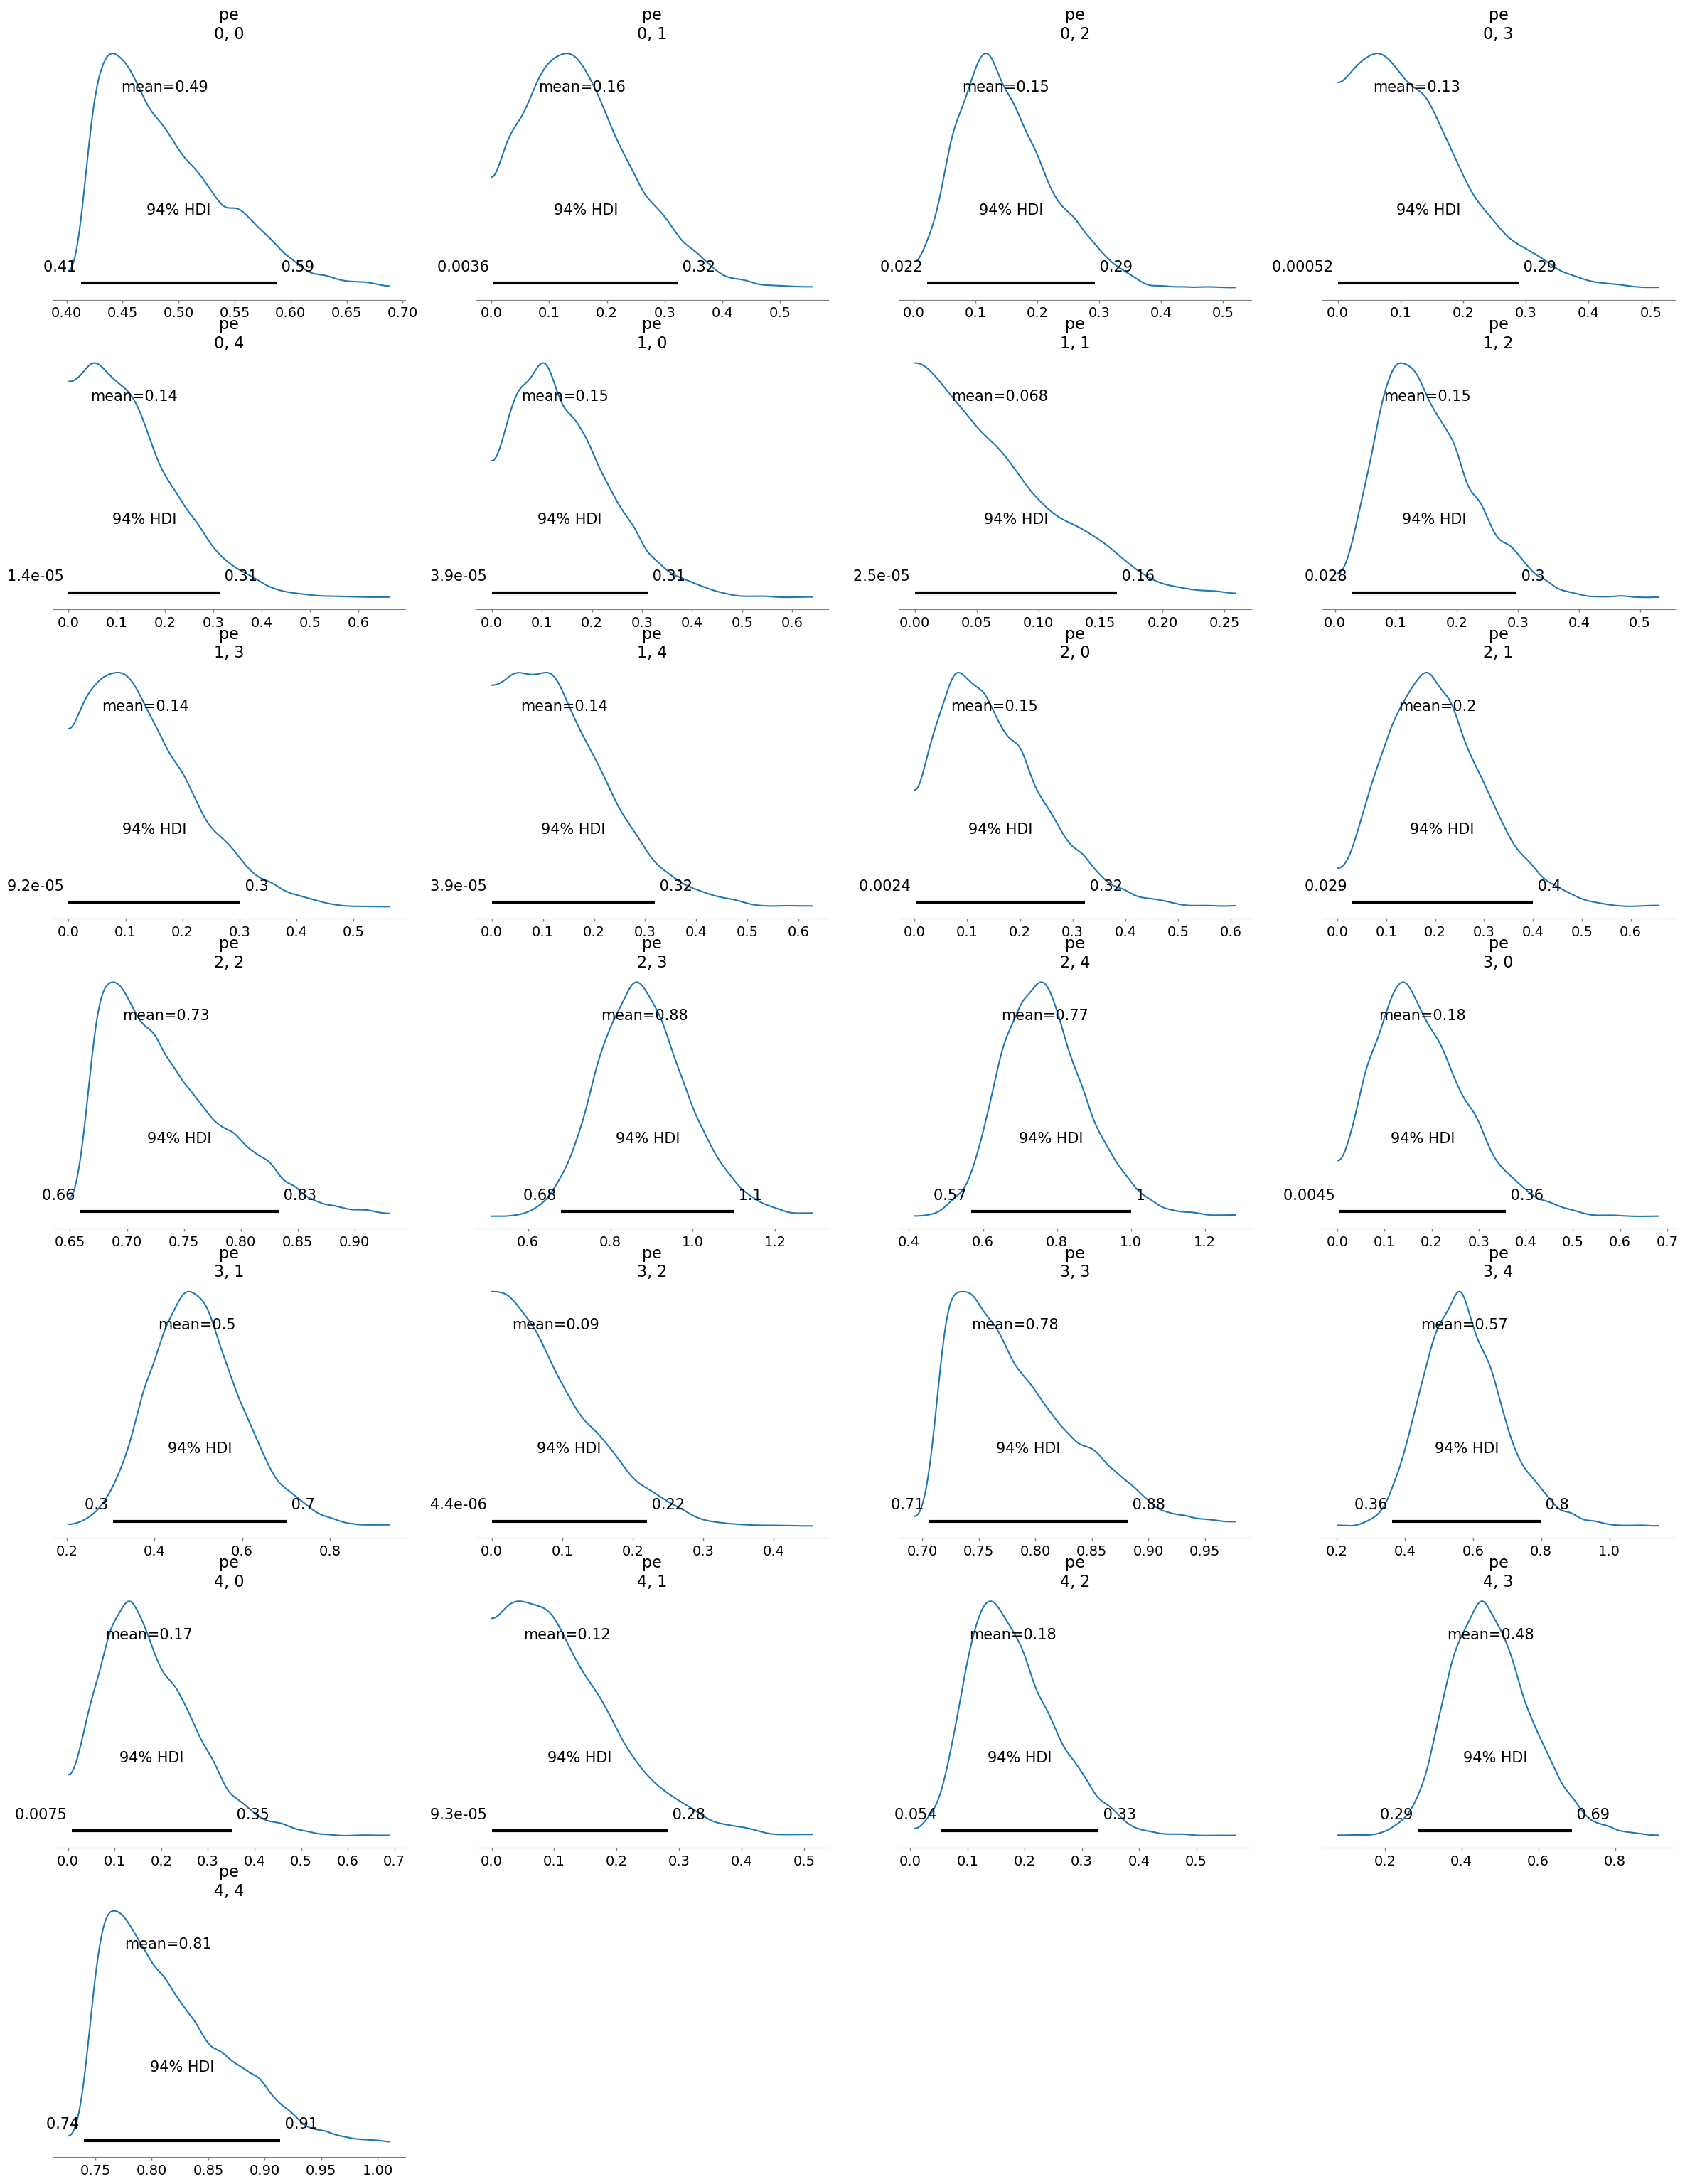

In [160]:
pm.plot_posterior(trace.posterior.pe)

In [14]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1.6, -0.7, -0.6],
       [-0. , -0.3,  0. , -1.5, -0.5],
       [ 0. ,  0. ,  0. , -0.5, -1.6]])

In [18]:
a = pm.summary(trace.posterior.pe_cross)
a[a['hdi_97%'] < -0.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"pe_cross[0, 0]",-2.532,1.437,-4.901,-0.225,0.023,0.017,3498.0,1933.0,1.00
"pe_cross[1, 1]",-2.518,1.442,-4.917,-0.240,0.024,0.017,3279.0,2434.0,1.00
"pe_cross[2, 2]",-2.494,1.460,-4.878,-0.178,0.023,0.017,3553.0,2067.0,1.00
"pe_cross[2, 3]",-0.590,0.239,-1.014,-0.100,0.008,0.006,894.0,745.0,1.00
"pe_cross[2, 4]",-0.563,0.173,-0.900,-0.249,0.006,0.004,914.0,1280.0,1.00
"pe_cross[3, 1]",-0.728,0.268,-1.225,-0.209,0.007,0.005,1538.0,1303.0,1.00
"pe_cross[3, 4]",-0.936,0.183,-1.284,-0.590,0.006,0.004,1044.0,1709.0,1.00
"pe_cross[4, 2]",-0.294,0.131,-0.535,-0.061,0.005,0.004,667.0,849.0,1.01
"pe_cross[4, 3]",-0.497,0.222,-0.854,-0.045,0.006,0.004,1228.0,1062.0,1.00
"pe_cross[4, 4]",-2.478,1.460,-4.934,-0.236,0.022,0.016,3782.0,2505.0,1.00


In [71]:
pm.summary(trace.posterior.pe_own)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pe_own[0],-1.510,0.632,-2.150,-0.829,0.446,0.377,3.0,16.0,2.19
pe_own[1],-0.990,0.589,-1.587,-0.352,0.416,0.352,3.0,16.0,2.19
pe_own[2],-1.740,0.553,-2.302,-1.138,0.390,0.330,3.0,16.0,2.19
pe_own[3],-1.645,0.592,-2.245,-1.004,0.417,0.353,3.0,16.0,2.21
pe_own[4],-1.627,0.586,-2.221,-0.993,0.413,0.350,3.0,16.0,2.19


In [87]:
trace.sample_stats.diverging

<xarray.DataArray 'diverging' (chain: 2, draw: 2000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

/home/kirill/.conda/envs/py311/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (165) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'intercept\n0'}>,
        <Axes: title={'center': 'intercept\n1'}>,
        <Axes: title={'center': 'intercept\n2'}>,
        <Axes: title={'center': 'day_effect\n0, 0'}>],
       [<Axes: title={'center': 'day_effect\n0, 1'}>,
        <Axes: title={'center': 'day_effect\n0, 2'}>,
        <Axes: title={'center': 'day_effect\n0, 3'}>,
        <Axes: title={'center': 'day_effect\n0, 4'}>],
       [<Axes: title={'center': 'day_effect\n0, 5'}>,
        <Axes: title={'center': 'day_effect\n0, 6'}>,
        <Axes: title={'center': 'day_effect\n0, 7'}>,
        <Axes: title={'center': 'day_effect\n0, 8'}>],
       [<Axes: title={'center': 'day_effect\n0, 9'}>,
        <Axes: title={'center': 'day_effect\n0, 10'}>,
        <Axes: title={'center': 'day_effect\n0, 11'}>,
        <Axes: title={'center': 'day_effect\n0, 12'}>],
       [<Axes: title={'center': 'day_effect\n0, 13'}>,
        <Axes: title={'center': 'day_effect\n1, 0'}>,
        <Axes: title={'center': 

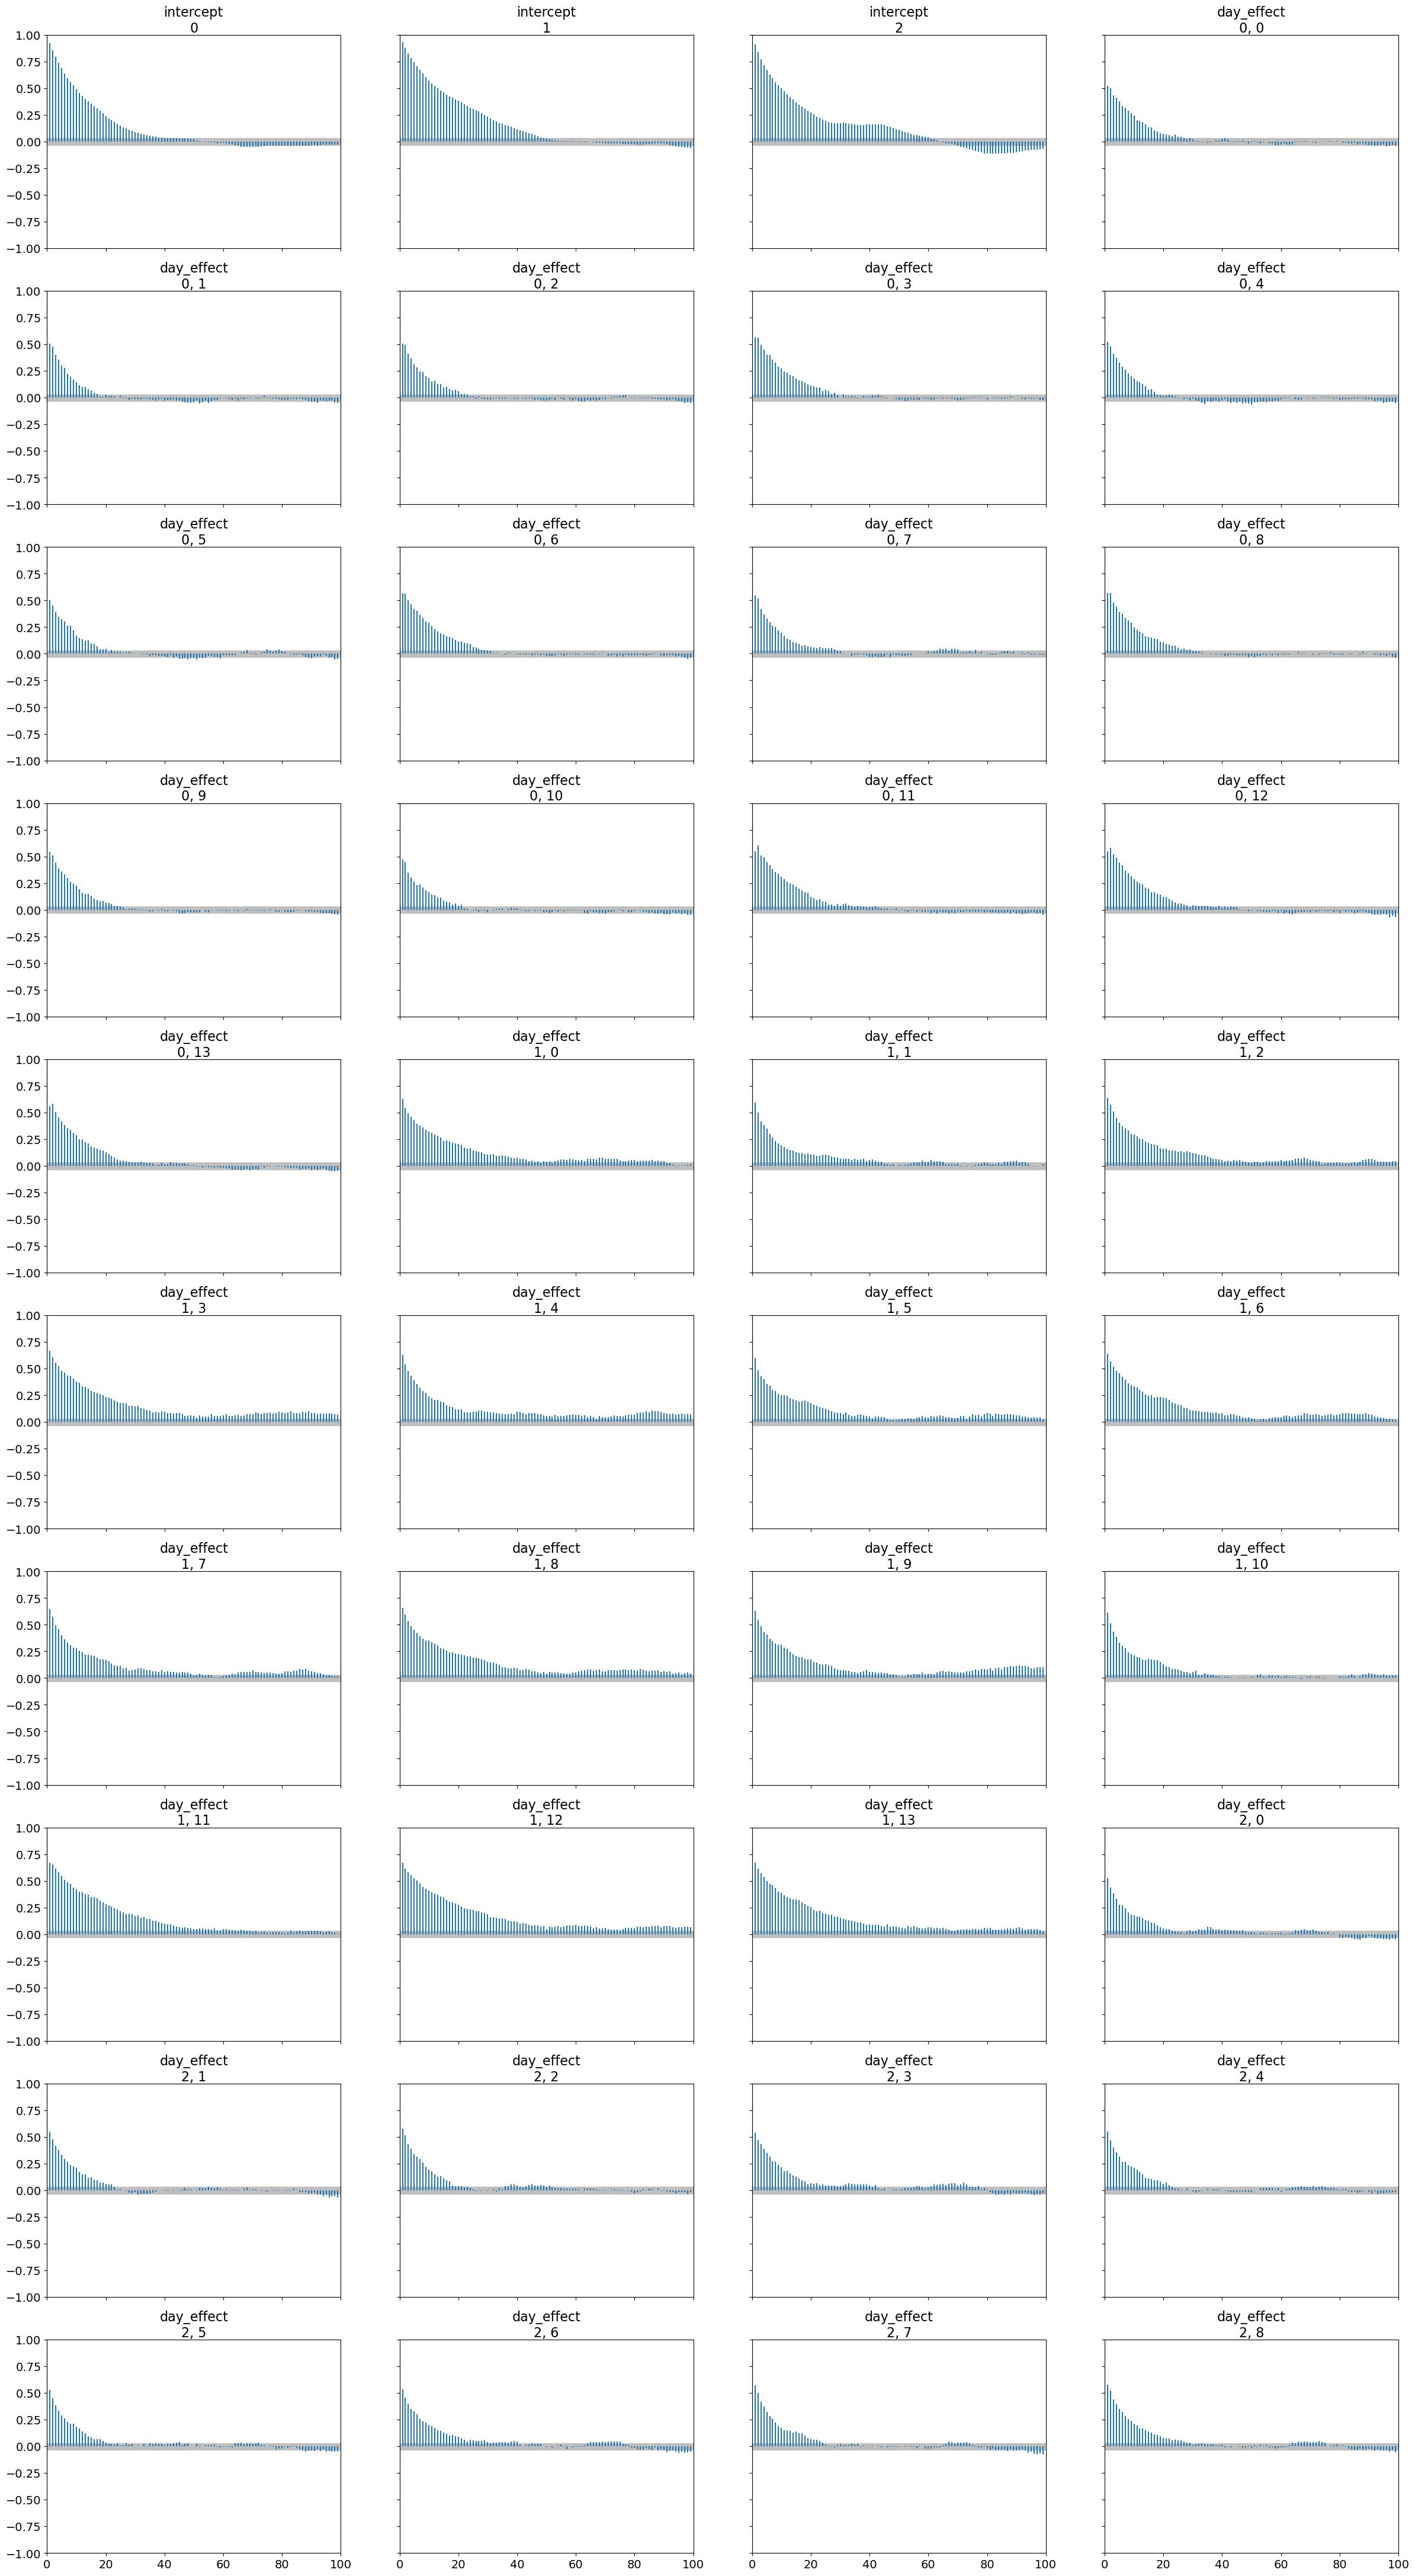

In [27]:
import arviz as az
az.plot_autocorr(trace)

array([[<Axes: title={'center': 'pe_cross\n0, 0'}>,
        <Axes: title={'center': 'pe_cross\n0, 1'}>,
        <Axes: title={'center': 'pe_cross\n0, 2'}>,
        <Axes: title={'center': 'pe_cross\n0, 3'}>],
       [<Axes: title={'center': 'pe_cross\n0, 4'}>,
        <Axes: title={'center': 'pe_cross\n1, 0'}>,
        <Axes: title={'center': 'pe_cross\n1, 1'}>,
        <Axes: title={'center': 'pe_cross\n1, 2'}>],
       [<Axes: title={'center': 'pe_cross\n1, 3'}>,
        <Axes: title={'center': 'pe_cross\n1, 4'}>,
        <Axes: title={'center': 'pe_cross\n2, 0'}>,
        <Axes: title={'center': 'pe_cross\n2, 1'}>],
       [<Axes: title={'center': 'pe_cross\n2, 2'}>,
        <Axes: title={'center': 'pe_cross\n2, 3'}>,
        <Axes: title={'center': 'pe_cross\n2, 4'}>,
        <Axes: title={'center': 'pe_cross\n3, 0'}>],
       [<Axes: title={'center': 'pe_cross\n3, 1'}>,
        <Axes: title={'center': 'pe_cross\n3, 2'}>,
        <Axes: title={'center': 'pe_cross\n3, 3'}>,
        

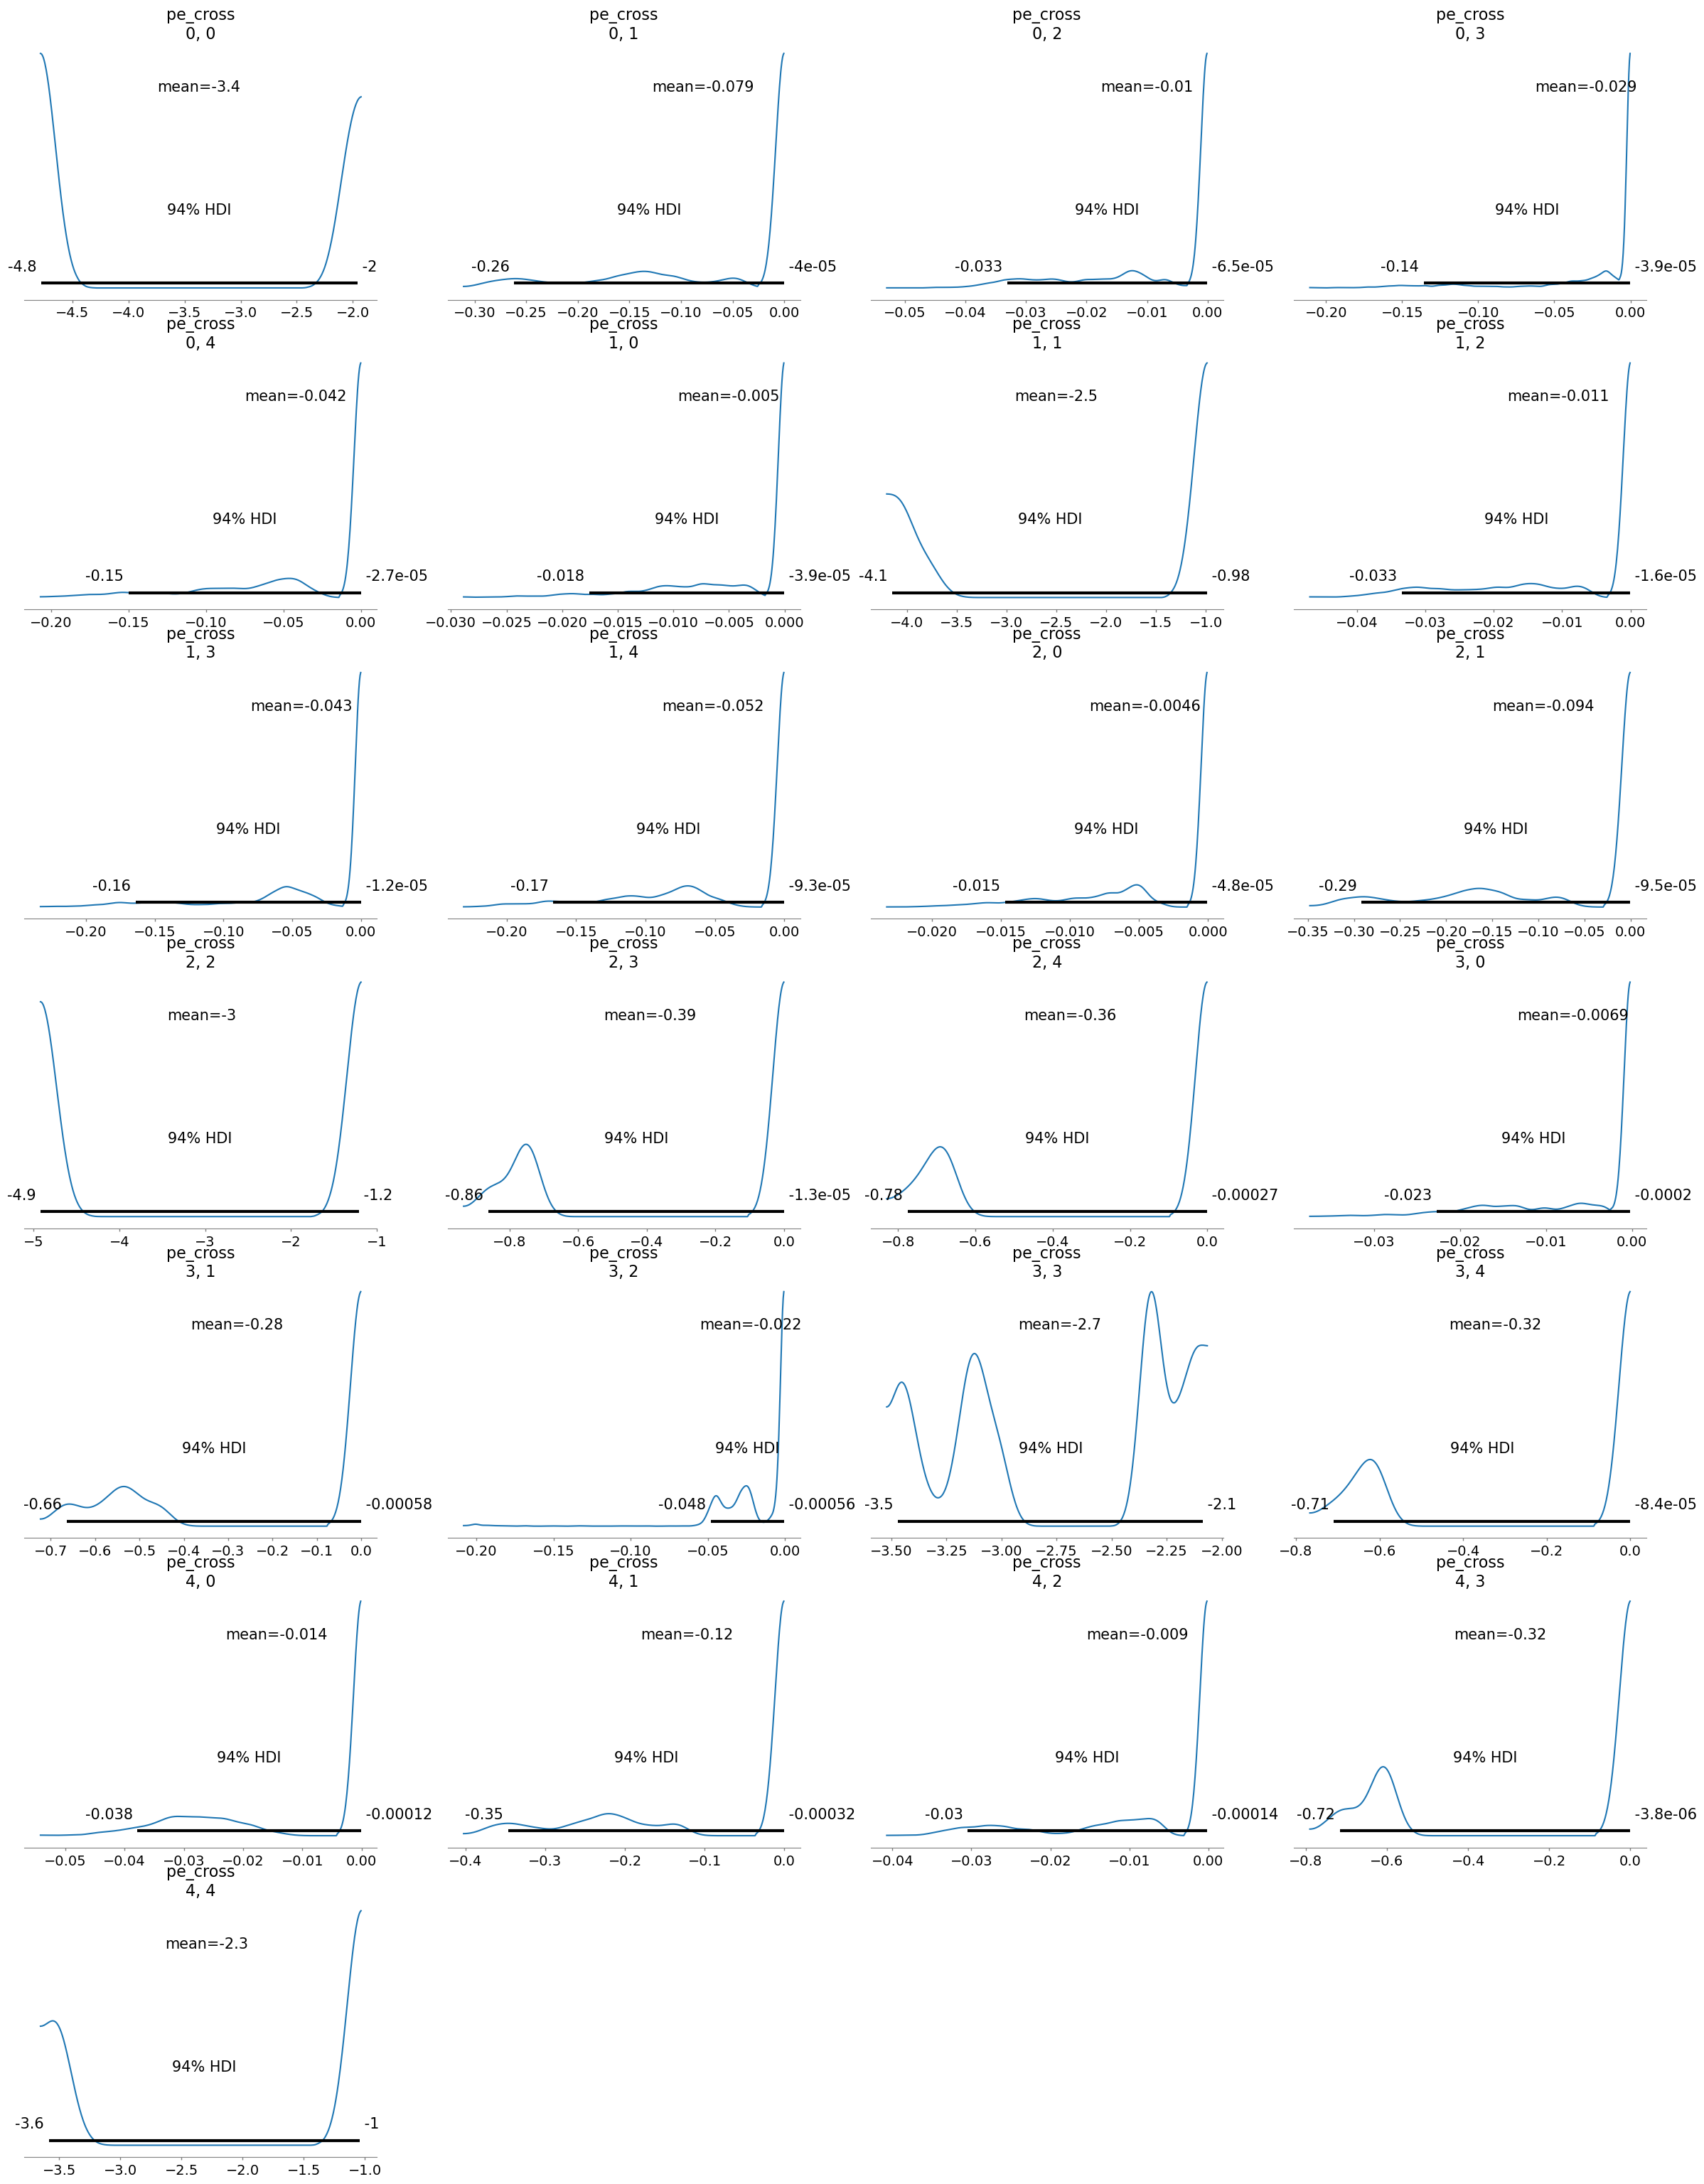

In [74]:
pm.plot_posterior(trace.posterior.pe_cross)

In [16]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1.6, -0.7, -0.6],
       [-0. , -0.3,  0. , -1.5, -0.5],
       [ 0. ,  0. ,  0. , -0.5, -1.6]])

In [21]:
pm.summary(trace.posterior.pe_cross[:,1500:])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"pe_cross[0, 0]",-2.419,0.930,-3.352,-1.476,0.652,0.551,3.0,11.0,2.32
"pe_cross[0, 1]",-0.335,0.335,-0.687,-0.000,0.235,0.199,3.0,13.0,2.30
"pe_cross[0, 2]",-0.001,0.001,-0.001,-0.000,0.000,0.000,3.0,17.0,2.32
"pe_cross[0, 3]",-0.001,0.000,-0.001,-0.000,0.000,0.000,14.0,15.0,1.72
"pe_cross[0, 4]",-0.000,0.000,-0.000,-0.000,0.000,0.000,17.0,23.0,1.31
"pe_cross[1, 0]",-0.004,0.004,-0.008,-0.000,0.003,0.002,3.0,29.0,2.20
"pe_cross[1, 1]",-2.608,0.814,-3.431,-1.788,0.571,0.482,3.0,11.0,2.33
"pe_cross[1, 2]",-0.001,0.001,-0.001,-0.000,0.000,0.000,2.0,12.0,2.80
"pe_cross[1, 3]",-0.012,0.028,-0.085,-0.000,0.015,0.011,3.0,11.0,2.03
"pe_cross[1, 4]",-0.000,0.000,-0.001,-0.000,0.000,0.000,2.0,11.0,2.50


In [13]:
pm.summary(trace.posterior.day_effect*trace.posterior.store_effect)

KeyboardInterrupt: 

In [10]:
price_elasticity_matrix

array([[-1.2,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1.6, -0.7, -0.6],
       [-0. , -0.3,  0. , -1.5, -0.5],
       [ 0. ,  0. ,  0. , -0.5, -1.6]])

In [112]:

with pm.Model() as model:
    intercept = pm.Normal('intercept', 0, 5)
    stdev = pm.HalfNormal('stdev', 3)
    pe = pm.HalfCauchy('pe', 0.5, shape=data_params['n_items'])
    
    day_effect_hat = pm.Normal('day_effect', 1, 0.3, shape=data_params['n_days']-1)
    day_effect = pt.concatenate([[1.], day_effect_hat])

    store_effect_hat = pm.Normal('store_effect', 1, 0.3, shape=data_params['n_stores']-1)
    store_effect = pt.concatenate([[1.], store_effect_hat])

    q = intercept + \
        np.log(df['price'].values) * -pe[dfm['item_id'].values] + \
        pm.math.exp(day_effect[dfm['day'].values]) + \
        pm.math.exp(store_effect[dfm['store'].values])
        
    likelyhood = pm.Normal('quantity', mu=q, sigma=stdev, observed=np.log(dfm['quantity'].values))
    trace = pm.sample(tune=25000, draws=10000, chains=3, nuts_sampler='numpyro', nuts_sampler_kwargs={'chain_method':"vectorized"})


/home/kirill/.conda/envs/py311/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.167380
Sampling...


sample: 100%|██████████| 35000/35000 [1:00:47<00:00,  9.60it/s]


Sampling time =  1:00:50.135084
Transforming variables...
Transformation time =  0:00:00.067229


In [115]:
pm.summary(trace.posterior.pe)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pe[0],2.024,0.032,1.964,2.082,0.001,0.0,3863.0,6763.0,1.0
pe[1],1.654,0.029,1.600,1.707,0.000,0.0,3865.0,6831.0,1.0
pe[2],2.321,0.032,2.262,2.382,0.001,0.0,3865.0,6798.0,1.0
pe[3],2.313,0.028,2.260,2.366,0.000,0.0,3864.0,6877.0,1.0
pe[4],2.421,0.029,2.366,2.474,0.000,0.0,3867.0,6871.0,1.0


array([[<Axes: title={'center': 'pe\n0'}>,
        <Axes: title={'center': 'pe\n1'}>,
        <Axes: title={'center': 'pe\n2'}>],
       [<Axes: title={'center': 'pe\n3'}>,
        <Axes: title={'center': 'pe\n4'}>, <Axes: >]], dtype=object)

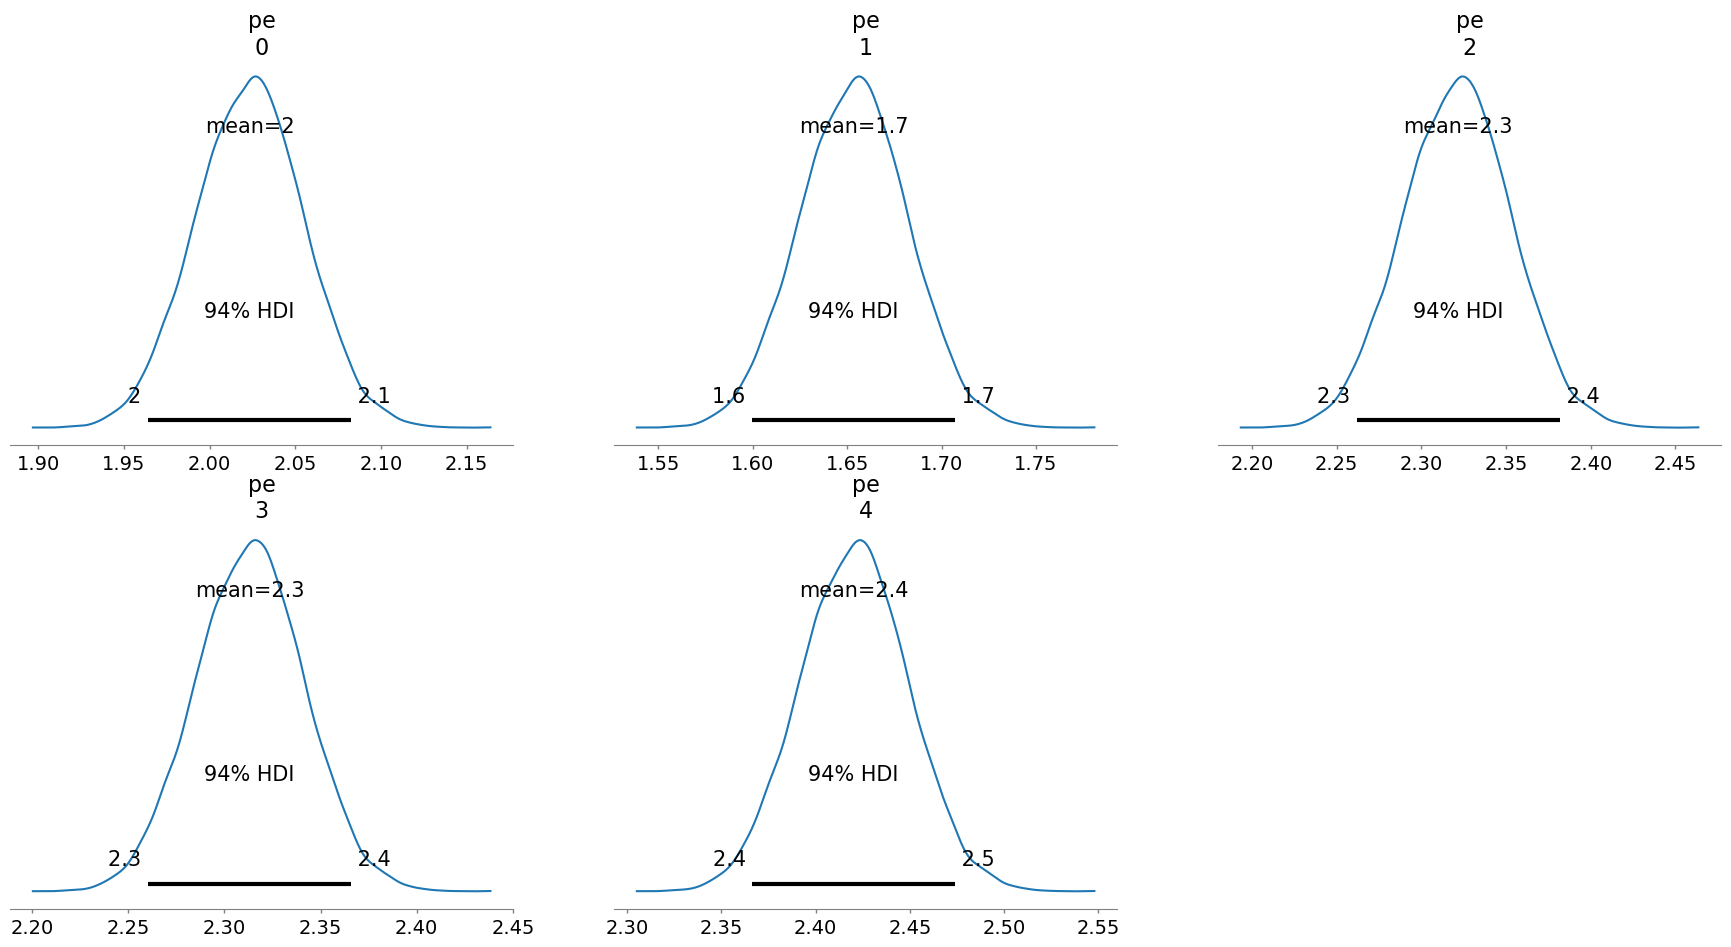

In [116]:
pm.plot_posterior(trace.posterior.pe)